**Analysis owner**: Tamiris Crepalde <br>
**Date**: 09/01/2023 <br>

This analysis pretends to do an Exploratory Data Analysis of a dateset related to cancellations of travel packages.

Packages are a type of travel product that include flight tickets and hotel reservations.

### Setup

In [2]:
import os
from datetime import datetime as dt

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# import squarify

import src.utils as utils
from GoogleUtils import GoogleUtils

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
gutils = GoogleUtils()

### Load data

In [4]:
root = os.getcwd()

In [6]:
query = utils.read_file(f'{root}/src/queries/package_cancellation_data.sql')
df_cancel = gutils.read_from_bq(query)

In [7]:
df_cancel.head()

,operation_order_id,operation_id,order_id,order_date,origin_city,order_origin_city,origin_state,origin_country,destination_type,destination_city,...,first_valid_date_brt,last_valid_date_brt,first_possible_wish_date_brt,first_wish_date_brt,second_wish_date_brt,third_wish_date_brt,operation_status_id,operation_status_name,last_update_status_date_brt,qty_status_changes
0,6111070362110856550,-5.000942e+18,-3866390300735638558,2019-11-21,São Paulo,São Paulo,São Paulo,Brasil,Nacional,Ilhéus,...,2020-03-01,2020-11-30,None,2020-07-31,2020-07-31,2020-07-31,2.0,Cotando aéreo,2020-03-10,2
1,48798535557898141,NaN,3219293283240330715,2020-05-19,Rio de Janeiro,Rio de Janeiro,Rio de Janeiro,Brasil,Internacional,Los Angeles,...,2021-03-01,2022-11-30,None,2022-08-01,2022-08-07,2022-08-13,NaN,None,2021-10-04,4
2,-2169900013421488023,NaN,-2499335070780683167,2020-05-25,São Paulo,São Paulo,São Paulo,Brasil,Internacional,Noord,...,2021-03-01,2022-11-30,None,2021-08-16,2021-09-13,2021-10-11,NaN,None,2021-06-11,3
3,-7312379598476760668,NaN,6308428119170665181,2020-06-09,São Paulo,São Paulo,São Paulo,Brasil,Internacional,Praga,...,2021-03-01,2022-11-30,None,2022-08-03,2022-08-10,2022-08-16,NaN,None,2021-11-04,3
4,-3801327626968567859,NaN,-7042664461408108529,2020-06-22,São Paulo,São Paulo,São Paulo,Brasil,Nacional,Marechal Deodoro,...,2021-03-01,2021-11-30,None,2021-08-08,2021-08-15,2021-08-22,NaN,None,2020-08-03,2


Save locally:

In [8]:
df_cancel.to_csv(f'{root}/src/data/cancellation_data.csv')

### Data Cleaning

We have a lot of null values:

In [9]:
df_cancel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305263 entries, 0 to 305262
Data columns (total 28 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   operation_order_id            305263 non-null  int64  
 1   operation_id                  158263 non-null  float64
 2   order_id                      305263 non-null  int64  
 3   order_date                    305263 non-null  object 
 4   origin_city                   305263 non-null  object 
 5   order_origin_city             305263 non-null  object 
 6   origin_state                  305263 non-null  object 
 7   origin_country                305263 non-null  object 
 8   destination_type              305263 non-null  object 
 9   destination_city              305263 non-null  object 
 10  destination_state             305263 non-null  object 
 11  destination_country           305263 non-null  object 
 12  qty_people                    305263 non-nul

- The feature `operation_id` indicates if the order started the process of being operated before the cancellation and the features `operation_status_id` and `operation_status_name` indicates the status of the operation process. The first feature we'll convert to boolean because we want to analyze if the client cancelled the order after the operation process started. 
- `origin_city` and `origin_state` miss more than half of the data, but `order_origin_city` has the same purpose of `origin_city`. So, we'll see if it's possible to consider the `order_origin_city` valid and if we can use it to try to fill up the missing data of `origin_state`. 
- We can drop the `origin_country` column because this product is offer only to Brazil.
- The feature `filled_form` is related to the client inform the desired dates to travel, so is enough if this information is boolean too. `first_form_fill_date_brt` and `last_form_fill_date_brt` are related to the first and last date in which the client filled up the form, we'll use these features only to verify if the process of filling up the form and the cancellation are close events.
- `first_possible_wish_date_brt` is completely empty, so we'll remove the column.
- The columns `first_wish_date_brt`, `second_wish_date_brt` and `third_wish_date_brt` are the wished dates to travel informed by half of the clients, at a first moment we'll not be concern about these information.
- The columns `operation_status_name` and `operation_status_id` are related to the status of the operation process, if a order was cancelled before the start of the operation, this information doesn't exists. So we'll use only the `operation_status_name` information, replacing the missing values with a non-started status name.
- The column `accommodation_type` has some missing data, we're going to look further on it before deciding if it will me removed or filled up.

Next we'll proceed to execute this modifications.

In [10]:
(df_cancel.isna().sum()/df_cancel.shape[0])*100

operation_order_id                0.000000
operation_id                     48.155197
order_id                          0.000000
order_date                        0.000000
origin_city                       0.000000
order_origin_city                 0.000000
origin_state                      0.000000
origin_country                    0.000000
destination_type                  0.000000
destination_city                  0.000000
destination_state                 0.000000
destination_country               0.000000
qty_people                        0.000000
qty_dailies                       0.000000
accommodation_type                8.014728
filled_form                       0.000000
first_form_fill_date_brt          0.000000
last_form_fill_date_brt           0.000000
first_valid_date_brt              0.000983
last_valid_date_brt               0.000983
first_possible_wish_date_brt    100.000000
first_wish_date_brt               0.001638
second_wish_date_brt              0.001638
third_wish_

Converting columns to boolean:

In [11]:
df = utils.convert_to_boolean(df_cancel, 'operation_id')
df = utils.convert_to_boolean(df, 'filled_form')

Looking at order_origin_city:

There's a lot of inconsistencies between the two cities columns, so we'll consider only the common information to fill up the state column.

In [12]:
df[['origin_city', 'order_origin_city']].loc[df[['origin_city', 'order_origin_city']].origin_city != df[['origin_city', 'order_origin_city']].order_origin_city].drop_duplicates()

,origin_city,order_origin_city
12027,Rio de Janeiro,São Paulo
136633,São Paulo,Cuiabá
223228,Rio de Janeiro,Su00e3o Paulo
239850,Porto Alegre,São Paulo
280099,Curitiba,Fortaleza
284545,São Paulo,Sao Paulo


In [13]:
city_state = df[['origin_city', 'order_origin_city', 'origin_state']].drop_duplicates().dropna(how='any')
city_state = city_state.loc[city_state.order_origin_city == city_state.origin_city]
city_state_dict = {city: city_state.loc[city_state.order_origin_city == city].origin_state.values[0] for city in city_state.order_origin_city.values}

In [14]:
city_state_dict

{'São Paulo': 'São Paulo',
 'Rio de Janeiro': 'Rio de Janeiro',
 'Belo Horizonte': 'Minas Gerais',
 'Belém': 'Pará',
 'Porto Alegre': 'Rio Grande do Sul',
 'Curitiba': 'Paraná',
 'Brasília': 'Distrito Federal',
 'Vitória': 'Espírito Santo',
 'Recife': 'Pernambuco',
 'Goiânia': 'Goiás',
 'Cuiabá': 'Mato Grosso',
 'Manaus': 'Amazonas',
 'Florianópolis': 'Santa Catarina',
 'Campo Grande': 'Mato Grosso do Sul',
 'Salvador': 'Bahia',
 'Natal': 'Rio Grande do Norte',
 'Aracaju': 'Sergipe',
 'Fortaleza': 'Ceará',
 'Foz do Iguaçu': 'Paraná',
 'Campinas': 'São Paulo',
 'Palmas': 'Tocantins',
 'Boa Vista': 'Roraima',
 'João Pessoa': 'Paraíba',
 'Maceió': 'Alagoas',
 'Macapá': 'Amapá',
 'Porto Velho': 'Rondônia',
 'Porto Seguro': 'Bahia',
 'Ribeirão Preto': 'São Paulo',
 'Vitoria da Conquista': 'Bahia',
 'Guarulhos': 'São Paulo',
 'Teresina': 'Piauí',
 'São Luís': 'Maranhão',
 'Rio Branco': 'Acre'}

In [15]:
df.loc[df.origin_state.isna(), 'origin_state'] = df['order_origin_city'].map(city_state_dict)

We were able to fill up all the missing state information:

In [16]:
(df.origin_state.isna().sum()/df.shape[0])*100

0.0

Drop some columns:

In [17]:
df = df.drop(['operation_order_id', 'operation_id', 'order_id', 'origin_country', 'first_possible_wish_date_brt', 'first_form_fill_date_brt', 'last_form_fill_date_brt', 'origin_city', 'first_wish_date_brt', 'second_wish_date_brt', 'third_wish_date_brt', 'operation_status_id'], axis=1)

Filling up the operation_status_name column:

In [18]:
df.loc[df.operation_status_name.isna(), 'operation_status_name'] = 'not started'

Looking at accommodation_type:

It's possible to notice that the column has the information of type varying even for the same room type. For instance, `Apartamento duplo` and `Apartamento duplo casal`. So we'll try to extract the main information of the column (individual, duplo, triplo, etc). In the cases where there's more than one option, we'll attribute a new type `multiple`. We'll attribute `not informed` for missing data.

In [19]:
df.loc[~df.accommodation_type.isna()].accommodation_type

0                          Apartamento individual ou duplo.
1                                        Apartamento Duplo.
2                                        Apartamento duplo.
3                                        Apartamento Duplo.
4                                        Apartamento duplo.
                                ...                        
305257    Quarto individual, duplo ou triplo, de acordo ...
305259                            Apartamento duplo casal. 
305260                            Apartamento duplo casal. 
305261                            Apartamento duplo casal. 
305262    Quarto individual, duplo ou triplo, de acordo ...
Name: accommodation_type, Length: 280797, dtype: object

In [20]:
df.loc[df.accommodation_type.isna(), 'accommodation_type'] = 'not informed'

In [21]:
df['accommodation_type'] = df.accommodation_type.str.lower()
df.loc[df.accommodation_type.str.contains(','), 'accommodation_type'] = 'multiple'
df.loc[df.accommodation_type.str.contains('individual'), 'accommodation_type'] = 'individual'
df.loc[df.accommodation_type.str.contains('dupl'), 'accommodation_type'] = 'duplo'
df.loc[df.accommodation_type.str.contains('tripl'), 'accommodation_type'] = 'triplo'

Now we can just drop the few rows with missing value:

In [22]:
df = df.dropna(how='any')

Now we're going to change the dtype of some columns:

In [23]:
df['order_date'] = pd.to_datetime(df['order_date'])
df['first_valid_date_brt'] = pd.to_datetime(df['first_valid_date_brt'])
df['last_valid_date_brt'] = pd.to_datetime(df['last_valid_date_brt'])
df['last_update_status_date_brt'] = pd.to_datetime(df['last_update_status_date_brt'])

df['qty_people'] = df['qty_people'].astype(int)
df['qty_dailies'] = df['qty_dailies'].astype(int)

### Analysis

#### Categorical

Let's start analyzing the data taking a look into the categorical data.

In [36]:
sns.set_style('darkgrid')
sns.set_palette(sns.color_palette("flare"))

In [45]:
categorical_features = df.select_dtypes(include=['object_']).columns
categorical_features

Index(['order_origin_city', 'origin_state', 'destination_type',
       'destination_city', 'destination_state', 'destination_country',
       'accommodation_type', 'filled_form', 'operation_status_name'],
      dtype='object')

##### Origins

In [26]:
origin_state = df.groupby('origin_state').count().order_date.reset_index()
origin_state = origin_state.rename(columns={'order_date': 'volume'}).sort_values('volume', ascending=False)
origin_state['percent'] = origin_state.volume/origin_state.volume.sum()

Most of the cancelled orders are with origin in the states of São Paulo, Rio de Janeiro, Minas Gerais and Distrito Federal.

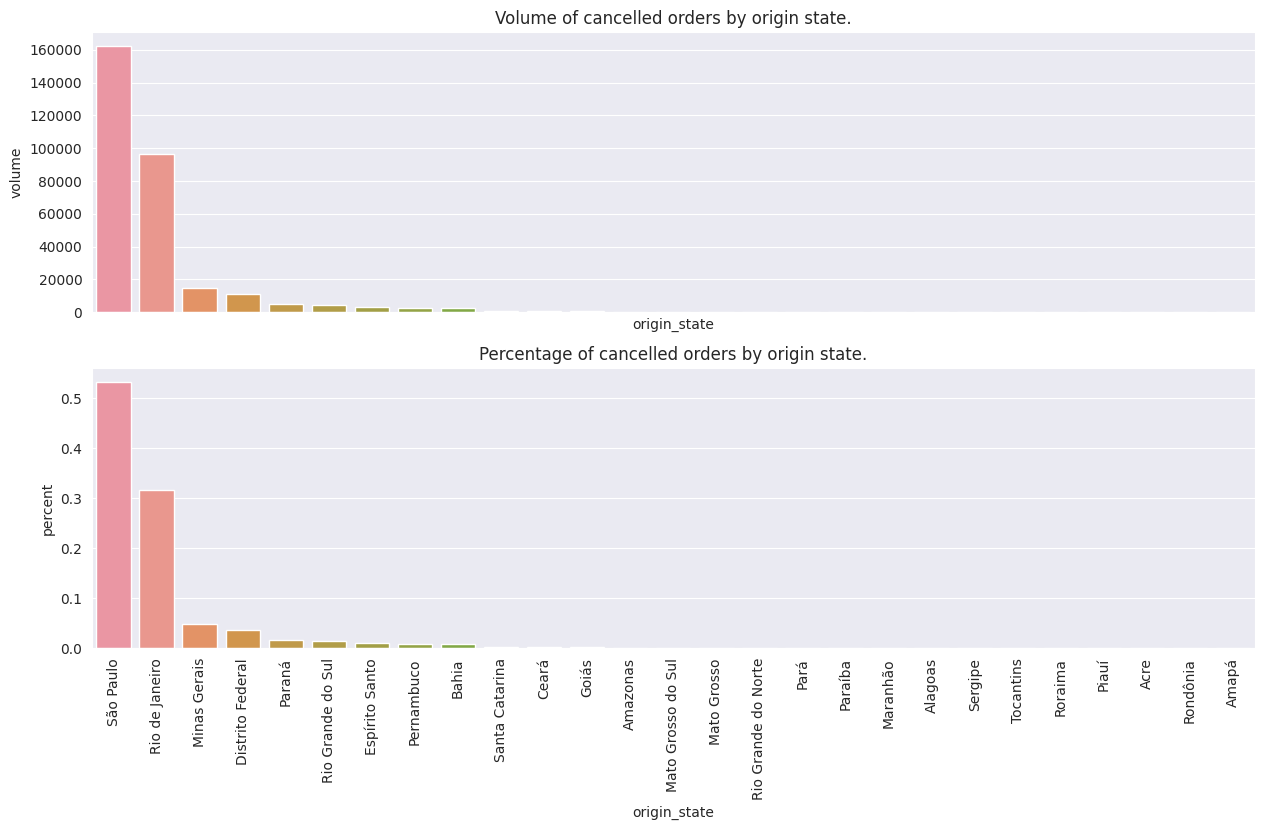

In [38]:
fig, ax = plt.subplots(2, sharex=True, figsize=(15,8))

sns.barplot(origin_state, x='origin_state', y='volume', ax=ax[0] ) #, palette=sns.color_palette())
sns.barplot(origin_state, x='origin_state', y='percent', ax=ax[1]) #, palette=sns.color_palette())

plt.xticks(rotation=90);
ax[0].set_title('Volume of cancelled orders by origin state.');
ax[1].set_title('Percentage of cancelled orders by origin state.');

In [28]:
origin_city = df.groupby('order_origin_city').count().order_date.reset_index()
origin_city = origin_city.rename(columns={'order_date': 'volume'}).sort_values('volume', ascending=False)
origin_city['percent'] = origin_city.volume/origin_city.volume.sum()

We can verify that the 5 top origin cities are São Paulo, Rio de Janeiro, Belo Horizonte, Brasília and Curitiba. They represent almost 90% of the origins in this dataset.

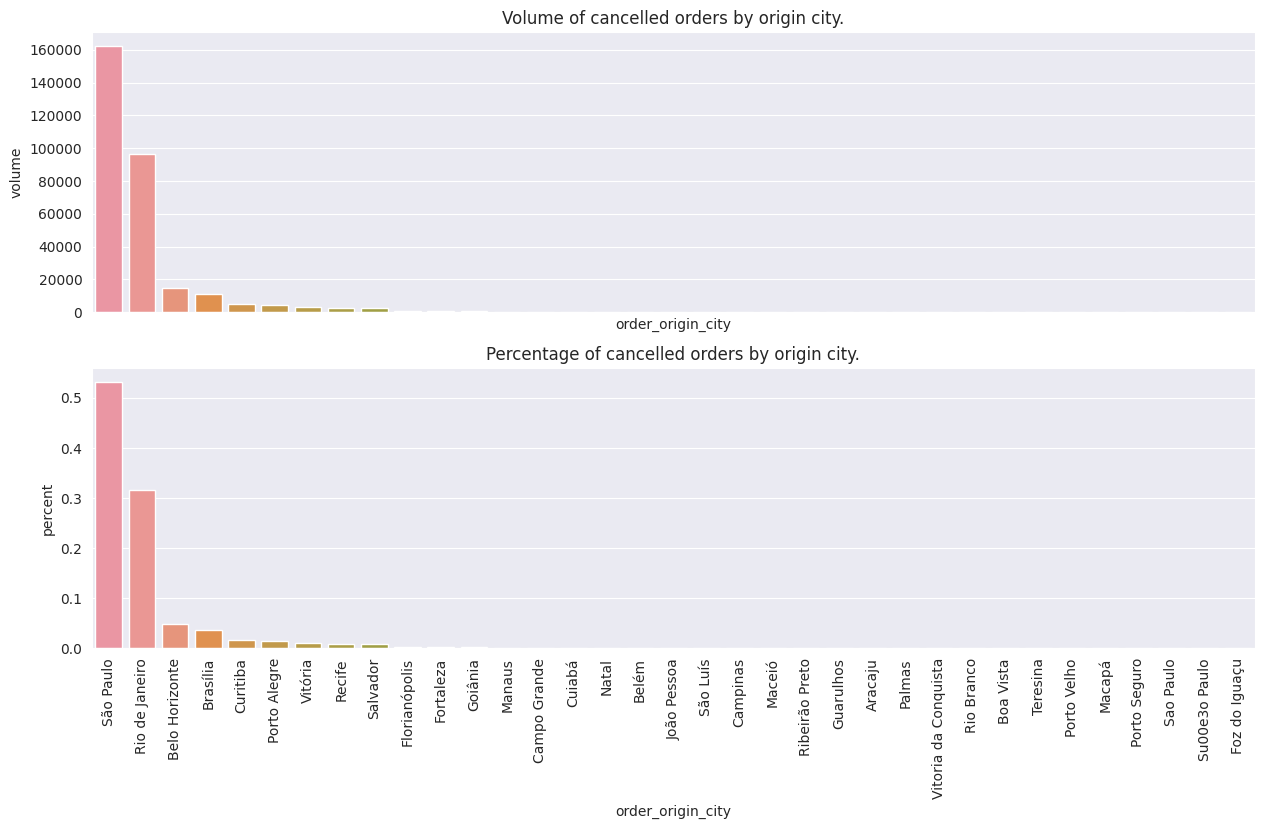

In [39]:
fig, ax = plt.subplots(2, sharex=True, figsize=(15,8))

sns.barplot(origin_city, x='order_origin_city', y='volume', ax=ax[0] ) #, palette=sns.color_palette())
sns.barplot(origin_city, x='order_origin_city', y='percent', ax=ax[1]) #, palette=sns.color_palette())

plt.xticks(rotation=90);
ax[0].set_title('Volume of cancelled orders by origin city.');
ax[1].set_title('Percentage of cancelled orders by origin city.');

##### Destinations

In [30]:
destination_type = df.groupby('destination_type').count().order_date.reset_index()
destination_type = destination_type.rename(columns={'order_date': 'volume'}).sort_values('volume', ascending=False)
destination_type['percent'] = destination_type['volume']/df.shape[0]

More than 50% of the cancellations have national destination (Brazil).

Text(0.5, 1.0, 'Percentage of cancellations by destinations type.')

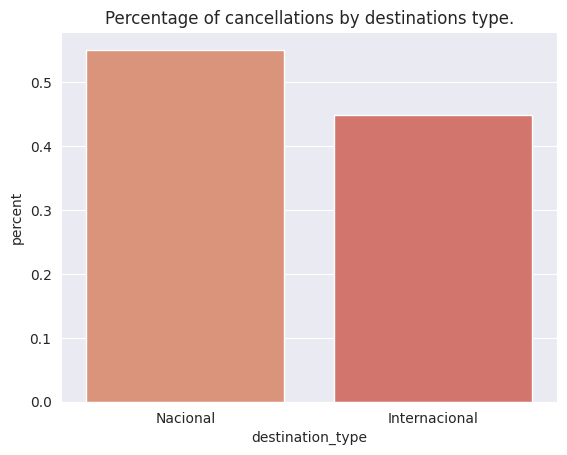

In [40]:
sns.barplot(destination_type, x='destination_type', y='percent')
plt.title('Percentage of cancellations by destinations type.')

In [32]:
destination_state = df.groupby('destination_state').count().order_date.reset_index()
destination_state = destination_state.rename(columns={'order_date': 'volume'}).sort_values('volume', ascending=False)
destination_state['percent'] = destination_state.volume/destination_state.volume.sum()

We limited the plot to the top 35 destination states to keep the graph interpretable. It's possible to verify that in the top 10 destination state we have only two that are international: Flórida and Quintana Roo.

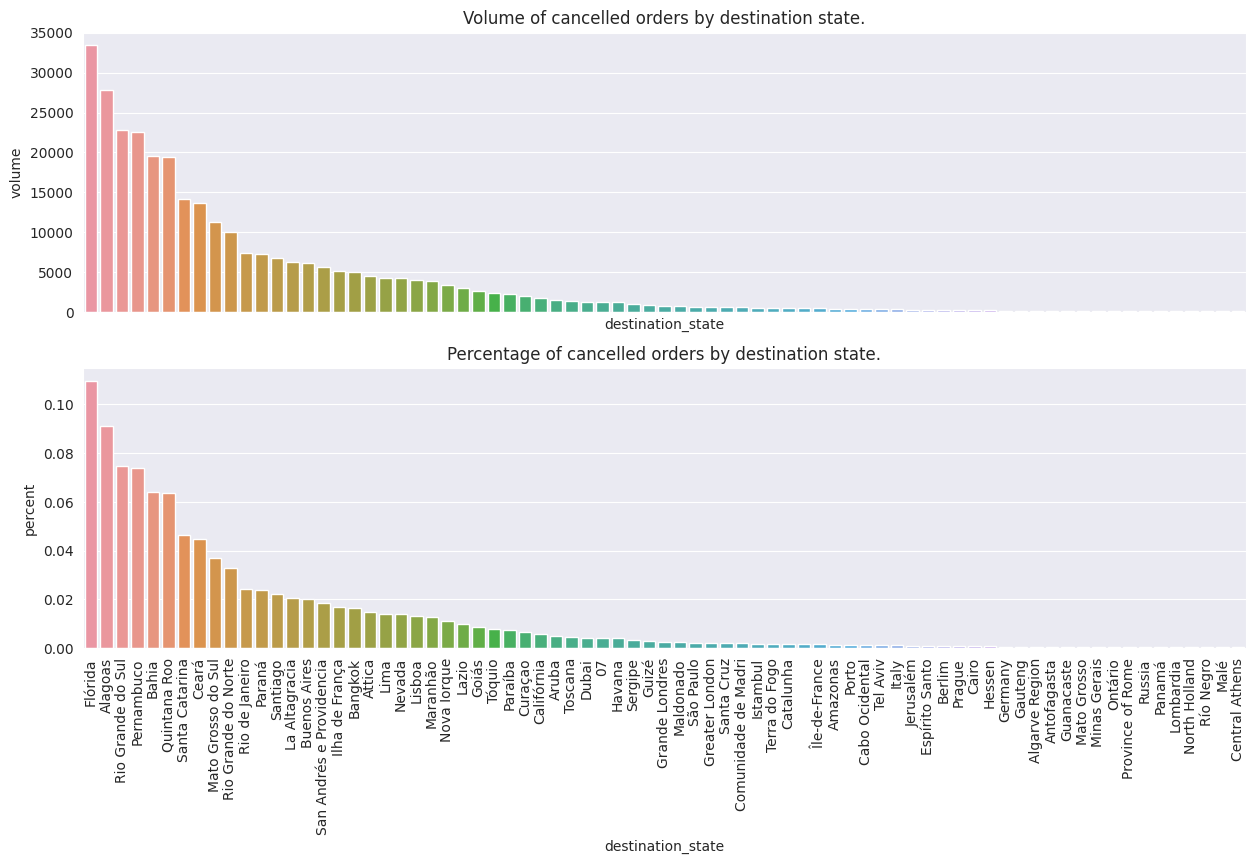

In [41]:
fig, ax = plt.subplots(2, sharex=True, figsize=(15,8))

sns.barplot(destination_state.loc[:35], x='destination_state', y='volume', ax=ax[0] ) #, palette=sns.color_palette());
sns.barplot(destination_state.loc[:35], x='destination_state', y='percent', ax=ax[1]) #, palette=sns.color_palette());

plt.xticks(rotation=90);
ax[0].set_title('Volume of cancelled orders by destination state.');
ax[1].set_title('Percentage of cancelled orders by destination state.');

In [34]:
destination_city = df.groupby('destination_city').count().order_date.reset_index()
destination_city = destination_city.rename(columns={'order_date': 'volume'}).sort_values('volume', ascending=False)
destination_city['percent'] = destination_city.volume/destination_city.volume.sum()

Among the top cities within cancellations, we have the to related to the international states mentioned before: Orlando (Florida) and Cancún (Quintana Roo).And a lot of Brazilian cities.

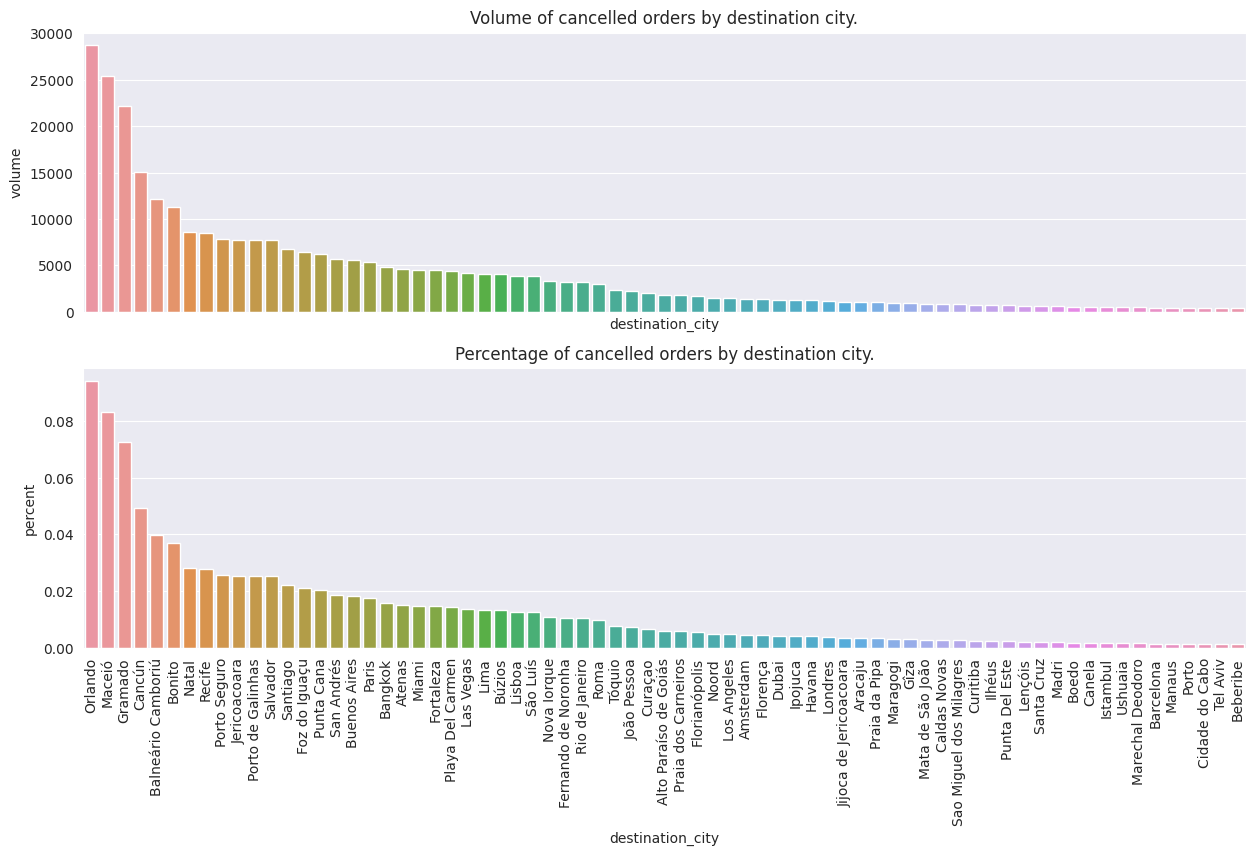

In [42]:
fig, ax = plt.subplots(2, sharex=True, figsize=(15,8))

sns.barplot(destination_city.loc[:30], x='destination_city', y='volume', ax=ax[0] ) #, palette=sns.color_palette())
sns.barplot(destination_city.loc[:30], x='destination_city', y='percent', ax=ax[1]) #, palette=sns.color_palette())

plt.xticks(rotation=90);
ax[0].set_title('Volume of cancelled orders by destination city.');
ax[1].set_title('Percentage of cancelled orders by destination city.');

TO DO **maybe try to plot a Sankey graph**

##### Accomodations

In [53]:
accommod = df.groupby('accommodation_type').count().order_date.reset_index()
accommod = accommod.rename(columns={'order_date': 'volume'}).sort_values('volume', ascending=False)
accommod['percent'] = accommod.volume/accommod.volume.sum()

Only 4 accommodation types correspond to 99% of the cases, so we'll consider only this 4 categories.

In [61]:
accommod.head()

,accommodation_type,volume,percent
9,duplo,136144,0.445994
13,multiple,130194,0.426502
14,not informed,24466,0.080148
12,individual,12420,0.040687
20,standard.,1131,0.003705


Text(0.5, 1.0, 'Percentage of the top 4 destination types.')

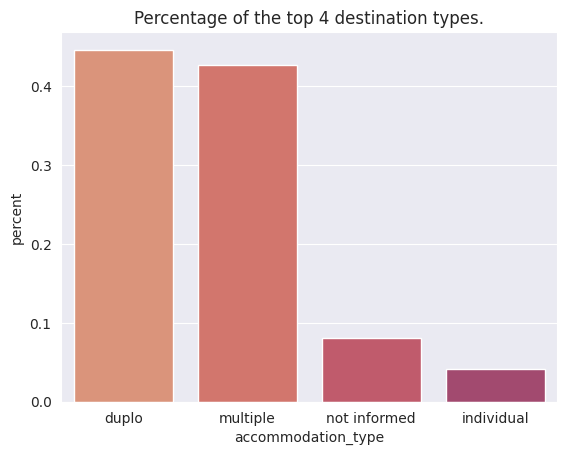

In [67]:
sns.barplot(accommod[:4], x='accommodation_type', y='percent')
plt.title('Percentage of the top 4 destination types.')

In [83]:
df = df.loc[df['accommodation_type'].isin(accommod[:4]['accommodation_type'])]

##### Filled Forms

In [70]:
forms = df.groupby('filled_form').count().order_date.reset_index()
forms = forms.rename(columns={'order_date': 'volume'}).sort_values('volume', ascending=False)
forms['percent'] = forms.volume/forms.volume.sum()

In all cases the form was filled up, so we can discard this feature.

In [71]:
forms.head()

,filled_form,volume,percent
0,True,305260,1.0


In [78]:
df = df.drop('filled_form', axis=1)

##### Status

In [84]:
status = df.groupby('operation_status_name').count().order_date.reset_index()
status = status.rename(columns={'order_date': 'volume'}).sort_values('volume', ascending=False)
status['percent'] = status.volume/status.volume.sum()

For the operation_status_name, seven categories correspond to 99% of the samples. We'll restrict the dataset to these cases.

An interesting insight is that almost 50% of the cases was cancelled before starting the operation.

In [89]:
status.head(7)

,operation_status_name,volume,percent
12,not started,146012,0.481532
4,Cancelada,113424,0.374060
1,Atribuído,14261,0.047031
6,Cotando aéreo,13753,0.045356
10,"Finalizado, voucher emitido",9652,0.031831
2,Aéreo cotado,2872,0.009472
8,Cotação aérea rejeitada,1516,0.005000


In [88]:
status[:7].sum()

operation_status_name    not startedCanceladaAtribuídoCotando aéreoFina...
volume                                                              301490
percent                                                           0.994281
dtype: object

In [90]:
df = df.loc[df['operation_status_name'].isin(status[:7]['operation_status_name'])]

#### Not Categorical

In [97]:
not_categorical = np.setdiff1d(df.columns, categorical_features)
not_categorical

array(['first_valid_date_brt', 'last_update_status_date_brt',
       'last_valid_date_brt', 'order_date', 'qty_dailies', 'qty_people',
       'qty_status_changes'], dtype=object)